# Project: Investigate The Movie Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
> The analysis uses a dataset comming from The Movie Database ([TMDb](https://www.themoviedb.org/about)). This is a community build movie and TV database added by TMDb community since 2008. The dataset has more than ten thousand movies, one per line and includes features like:
- original_tile
- cast
- budget
- revenue
- release_year and release_date
- director
- popularity

> This report will try to respond to the followind questions:
- Which months are popular movies released?
- How popularity trending over the time?
- Which actors played in the most movies?
- What kinds of properties are associated with movies that have high revenues?
- Which directors directed the most movies?
- How runtime trending over the time?


Download the dataset

In [81]:
# !wget -q https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv

Import used libraries and set up defaults

In [3]:
import pandas as pd
import datetime 
import numpy as np
import matplotlib.pyplot as plt
import calendar
import seaborn as sns

sns.set(style="ticks", color_codes=True)
pd.set_option('display.max_columns', 30)
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

**Load the dataset and take a look on some values**
- Columns like cast, keywords, genres, production_companies are separated by a vertical bar
- Columns like id, imdb_id, homepage, tagline, overview don't seem usefull for this anlysis
- In order to compare budgets and revenue I should probably use the adjusted values

In [4]:
df = pd.read_csv('tmdb-movies.csv')
df.head(4)
SEP="|"

In [5]:
df.drop(['id', 'imdb_id', 'homepage', 'tagline', 'overview'], axis=1, inplace=True)

**Inspect dataset fields**
- We have 10866 rows in the dataset and 21 columns
- Column types seem to be mostly ok
- There are some columns with a lot of null values
- Release date is represented as an a string

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 16 columns):
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
director                10822 non-null object
keywords                9373 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              10866 non-null float64
revenue_adj             10866 non-null float64
dtypes: float64(4), int64(5), object(7)
memory usage: 1.3+ MB


**Convert release_date from string to date**
- when converting month/day/year to date I had a problem with dates for old movies like 11/15/66
- I fixed this issue substracting 100 years for all dates above 2050, the list is not from the future

In [7]:
df['release_date'] = df['release_date'].astype('datetime64[ns]')\
    .apply(lambda x: x if x.year < 2050 else x-pd.DateOffset(years=100))

**Inspect the dataset with describe**
- Popularity is between 0 and 33
- Budgets are between 0 and 400M, more than 50% seem to have budget 0, this can be a problem in some cases
- Revenues are between 0 and 2.7B, also more than 50% seem to gain 0
- Runtime is between 0 and 15h, we have to deal with 0 and understand why this range
- Votes are between 10 and 10k
- We have movies between 1960 and 2015

In [8]:
df.describe()

,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


### Data Cleaning

**Check and remove duplicate lines**

In [9]:
print("I dropped %s duplicated row(s)" % df.duplicated().sum())
df.drop_duplicates(inplace=True)

I dropped 1 duplicated row(s)


**Check empty values**
- There are a lot of empty values in the columns: keywords and production_companies
- I will remove the keywords, but I think some figures on production_companies are interesting
- There are a few movies without cast, director or genre that can be removed

In [10]:
df.isnull().sum()

popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
director                  44
keywords                1493
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [11]:
df.drop(['keywords'], axis=1, inplace=True)
df.dropna(subset=['cast', 'director', 'genres'], inplace = True)

Drop movies with runtime 0

In [12]:
df.drop(df[df.runtime == 0].index, inplace=True)

Replace empty production_company with "Other"

In [13]:
df['production_companies'].fillna('Other', inplace=True)

Check there are no more empty values

In [14]:
df.isnull().sum().sum()

0

To simplify the analysis for profit related questions I will create a dataset without the movies that don't have a specified budget

In [15]:
dfProfit = df[df.budget > 0].copy()

**Save the resulted datasets**

In [16]:
df.to_csv('tmdb-movies-cleaned.csv', index=False)
dfProfit.to_csv('tmdb-movies-profit-cleaned.csv', index=False)

In [17]:
df = pd.read_csv('tmdb-movies-cleaned.csv')
dfProfit = pd.read_csv('tmdb-movies-profit-cleaned.csv')

Split compound columns
- will implement the same mechanism for all compound columns
- some of the movies have a lot of directors, will keep only 5

In [18]:
def split_compound_column(inputDf, column, prefix, separator='|'):
    # split column by separator
    dfColSplit = inputDf[column].str.split(separator, expand=True, n=4)
    maxCastSplit = dfColSplit.shape[1]
        
    # rename new columns
    renameCastCols = {}
    for i in range(0,maxCastSplit):
        renameCastCols[i] = prefix + '_' + str(i)
    dfColSplit.rename(columns=renameCastCols, inplace=True)
    
    return dfColSplit

In [74]:
dfCast = split_compound_column(df, 'cast', 'actor')
dfGenres = split_compound_column(df, 'genres', 'genre')
dfDirectors = split_compound_column(df, 'director', 'director')
dfCompanies = split_compound_column(df, 'production_companies', 'production_company')

dfPopularity = df[['release_year', 'popularity']]

In [82]:
dfCast.head(4)

,actor_0,actor_1,actor_2,actor_3,actor_4
0,Chris Pratt,Bryce Dallas Howard,Irrfan Khan,Vincent D'Onofrio,Nick Robinson
1,Tom Hardy,Charlize Theron,Hugh Keays-Byrne,Nicholas Hoult,Josh Helman
2,Shailene Woodley,Theo James,Kate Winslet,Ansel Elgort,Miles Teller
3,Harrison Ford,Mark Hamill,Carrie Fisher,Adam Driver,Daisy Ridley


<a id='eda'></a>
## Exploratory Data Analysis

### Question 1 - Which months popular movies are released?

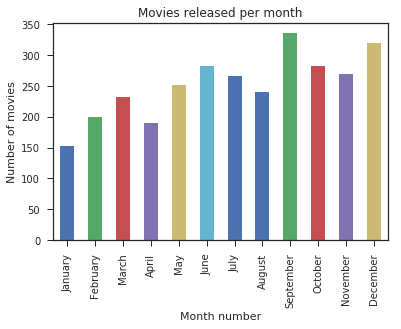

In [20]:
df['release_month'] = pd.to_datetime(df.release_date)
dfMonths = df[df.popularity > df.popularity.mean()]['release_month'].dt.month.value_counts().sort_index()

ax = dfMonths.plot(kind='bar', title="Movies released per month")
ax.set_xlabel('Month number')
ax.set_ylabel('Number of movies')
ax.set_xticklabels(list(calendar.month_name)[1:13]);

September, December and June seem to be the best release month for above average popular movies

### Question 2 - How popularity is trending over the time?

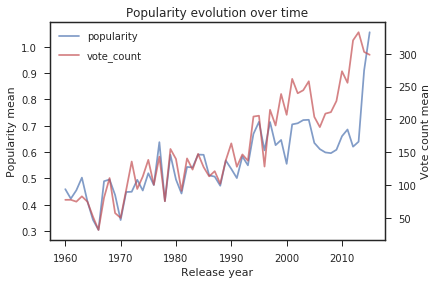

In [65]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

years_means = df.groupby('release_year')[['popularity', 'vote_count']].mean()
years_means.popularity.plot(title='Popularity evolution over time', ax=ax1, alpha=0.7)
years_means.vote_count.plot(ax=ax2,c='r', alpha=0.7)

ax1.set_xlabel('Release year')
ax1.set_ylabel('Popularity mean')
ax2.set_ylabel('Vote count mean')
ax1.legend()
ax2.legend(loc=(0.015,0.8));

Movies popularity is increasing and the tren=d is very similar to the votes count.

### Question 3 - Which actors played in the most movies?

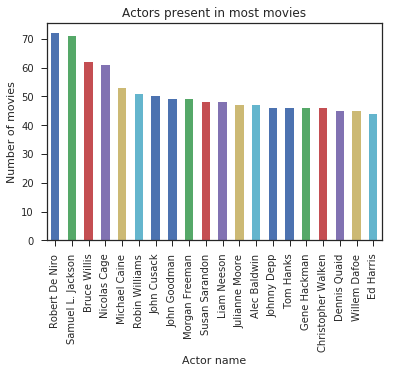

In [32]:
cast_list = df['cast'].str.cat(sep="|").split("|")
actors_movies_count = pd.DataFrame(list(zip(cast_list)), columns=['actor']).actor.value_counts()[:20]
ax = actors_movies_count.plot(kind='bar', title='Actors present in most movies')
ax.set_xlabel('Actor name')
ax.set_ylabel('Number of movies');

Most prolific actors seem to be Roberd De Niro, Samuel L. Jackson, Bruce willis and Nicolas Cage.

### Question 5 -  Which directors directed the most movies

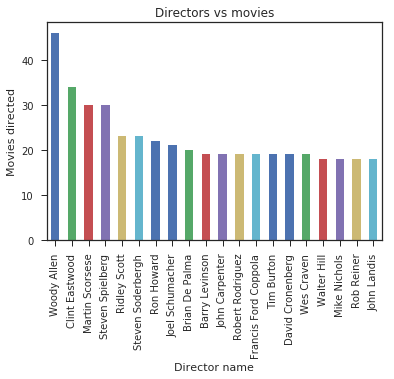

In [30]:
directors_list = df['director'].str.cat(sep="|").split("|")
directors_movies_count = pd.DataFrame(list(zip(directors_list)), columns=['actor']).actor.value_counts()[:20]
ax = directors_movies_count.plot(kind='bar', title='Directors vs movies')
ax.set_xlabel('Director name')
ax.set_ylabel('Movies directed');

In [26]:
first4_directors = directors_movies_count[:4]
print('Directors ' + ', '.join(first4_directors.index) + ' directed ' + str(first4_directors.sum()) + ' movies')

Directors Woody Allen, Clint Eastwood, Martin Scorsese, Steven Spielberg directed 140 movies


### Question 6 -  Which is the most profitable movie

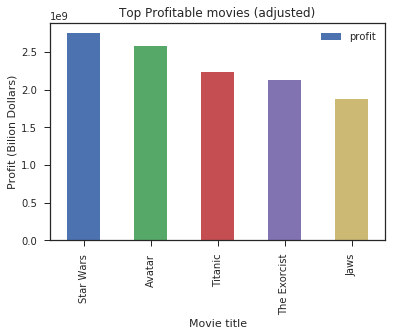

In [80]:
df['profit'] =  df['revenue_adj'] - df['budget_adj']
top_profitable_movies = df[['original_title', 'profit']].sort_values(by='profit', ascending=False)[:5]

ax = top_profitable_movies.plot(kind='bar', x='original_title',y='profit', title='Top Profitable movies (adjusted)')
ax.set_xlabel('Movie title')
ax.set_ylabel('Profit (Bilion Dollars)');

Star wars seems to be the most profitable movie followed by Avatar and Titanic

### Question 7 How runtime trending over the time?

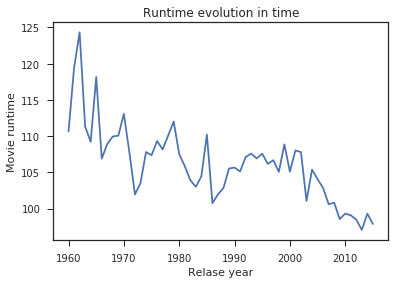

In [69]:
ax = df.groupby('release_year').runtime.mean().plot(title='Runtime evolution in time')
ax.set_xlabel('Relase year')
ax.set_ylabel('Movie runtime');

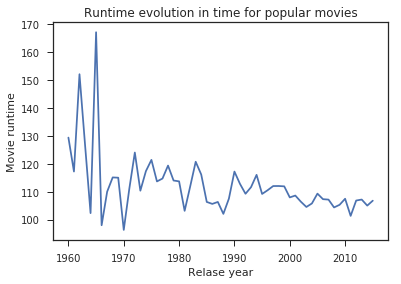

In [72]:
ax = df[df.popularity > df.popularity.mean()].groupby('release_year') \
    .runtime.mean().plot(title='Runtime evolution in time for popular movies')
ax.set_xlabel('Relase year')
ax.set_ylabel('Movie runtime');

Movies runtime has a descending trend. The average movie length decreased in the last 50 years from 115 minutes to under 100 minutes.

The above average popular movies in the last years seem to be stabilized at around 115 minutes.

<a id='conclusions'></a>
## Conclusions

I started the analysis trying to identify the most prolific month of the year when movies are released and my conclusion is that for popular movies September and December have the most releases.

Then I wanted to see how movies popularity evolved in time and if it is correlated to the number of votes. Probably people from The Movies Database are using the votes when calculating the popularity because they seem very correlated.

The next questions answered the questions about which is the actor with most movies and the post prolific director listed in this dataset. Robert De Niro and Woody Allen are in the top of this lists.

In the latest years, I knew that the movie Avatar was in the top profitable movies of all times and I wanted to check if this is still the case. It turns out that the movie Star Wars(1977) was more profitable, but this is true using the adjusted budgets and revenues and I can't be sure how the values were computed.

I was also interested to find out how movie lengths evolved in time, for all movies there seem to be a decreasing trend in time, but above average popular movies have now about 115 minutes in average

## Limitations
> - The analysis used The Movies Database, any movie not listed in this database can have an impact on the results
- During the analysis some Null values and columns were droped, this action can have an impact on the conclusions I made
- When analysing data with a lot of values like cast and directors a limit of 20 elements per movie was imposed. This can influence the end results
- Some of the conclusions use the fields budget_adj and revenue_adj, if this fields are not well computed the analysis results might not be ok

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])